In [10]:
print("Hello, World!")

Hello, World!


In [11]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from typing import Dict

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Get the dataset and extract it

In [12]:
data_dir = pathlib.Path('work/data/activity-recognition-dataset')

if not data_dir.exists():
  tf.keras.utils.get_file(
      'activity-recognition-dataset.zip',
      origin="https://archive.ics.uci.edu/ml/machine-learning-databases/00344/Activity%20recognition%20exp.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

Load the dataset


In [13]:
def load_datasets(base_dir: str):
    """
    Load dataset csvs from `activity-recognition-dataset` and return
    them in a dict.

    :return: A dict with `phones_accelerometer`, `phones_gyroscope`, 
        `watch_accelerometer`, `watch_gyroscope`
    """

    phones_accelerometer = pd.read_csv(os.path.join(base_dir, "Phones_accelerometer.csv"))
    phones_gyroscope = pd.read_csv(os.path.join(base_dir, "Phones_gyroscope.csv"))
    watch_accelerometer = pd.read_csv(os.path.join(base_dir, "Watch_accelerometer.csv"))
    watch_gyroscope = pd.read_csv(os.path.join(base_dir, "Watch_gyroscope.csv"))
    
    dataset = { 
        "phones_accelerometer" : phones_accelerometer, 
        "phones_gyroscope": phones_gyroscope,
        "watch_accelerometer": watch_accelerometer,
        "watch_gyroscope": watch_gyroscope
    }

    return dataset

In [14]:
def get_dataset(ds: Dict[str, pd.DataFrame], subset: str = "all"):
    """
    :param ds: Dataset dict
    :param type: One of `all`, `phones`, `watches`, `accelerometer`, `gyroscope`
    :return: A tuple with dataframe, one for each dataset
    """

    if subset == "phones":
        return ds["phones_accelerometer"], ds["phones_gyroscope"]

    if subset == "watches":
        return ds["watch_accelerometer"], ds["watch_gyroscope"]

    if subset == "accelerometer":
        return ds["phones_accelerometer"], ds["watch_accelerometer"]

    if subset == "gyroscope":
        return ds["phones_gyroscope"], ds["watch_gyroscope"]

    return ds["phones_accelerometer"], ds["phones_gyroscope"], ds["watch_accelerometer"], ds["watch_gyroscope"]

In [15]:
datasets = load_datasets(data_dir)
phones_accelerometer, phones_gyroscope, _, _ = get_dataset(datasets)

print(phones_accelerometer.head())
print(phones_accelerometer.columns)

   Index   Arrival_Time        Creation_Time         x         y         z  \
0      0  1424696633908  1424696631913248572 -5.958191  0.688065  8.135345   
1      1  1424696633909  1424696631918283972 -5.952240  0.670212  8.136536   
2      2  1424696633918  1424696631923288855 -5.995087  0.653549  8.204376   
3      3  1424696633919  1424696631928385290 -5.942718  0.676163  8.128204   
4      4  1424696633929  1424696631933420691 -5.991516  0.641647  8.135345   

  User   Model    Device     gt  
0    a  nexus4  nexus4_1  stand  
1    a  nexus4  nexus4_1  stand  
2    a  nexus4  nexus4_1  stand  
3    a  nexus4  nexus4_1  stand  
4    a  nexus4  nexus4_1  stand  
Index(['Index', 'Arrival_Time', 'Creation_Time', 'x', 'y', 'z', 'User',
       'Model', 'Device', 'gt'],
      dtype='object')


Some stats

In [16]:
def print_stats(df: pd.DataFrame):
    rows_no = df.shape[0]
    nulls_no = df['gt'].isnull().sum()

    print("Columns =", pd.unique(df['gt']))
    print("Number rows =", rows_no)
    print("Number of null values in gt =", nulls_no)
    print("Null rateo =", nulls_no / rows_no)

In [17]:
print_stats(phones_accelerometer)
print_stats(phones_gyroscope)

Columns = ['stand' nan 'sit' 'walk' 'stairsup' 'stairsdown' 'bike']
Number rows = 13062475
Number of null values in gt = 1783200
Null rateo = 0.13651317992953096
Columns = ['stand' nan 'sit' 'walk' 'stairsup' 'stairsdown' 'bike']
Number rows = 13932632
Number of null values in gt = 1869627
Null rateo = 0.13419051045057387


Remove nulls from accelerometer data

In [18]:
print(f"Length {phones_accelerometer.shape[0]}")
phones_accelerometer = phones_accelerometer.dropna()
print(f"Length {phones_accelerometer.shape[0]}")

Length 13062475
Length 11279275


Preprocessing. We try to keep noise low.

In [19]:
import matplotlib.gridspec as gridspec

def plot_seqs(df: pd.DataFrame):
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 3, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(df['x'])
    plt.title("x")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(df['y'])
    plt.title("y")

    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(df['z'])
    plt.title("z")

    plt.show()

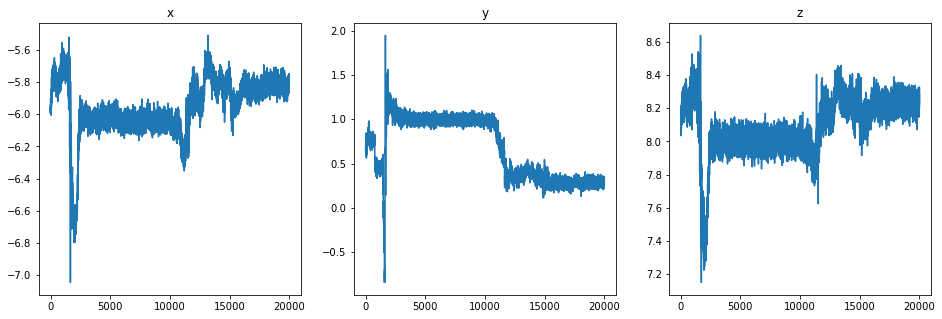

In [20]:

s1 = phones_accelerometer[:20000]

plot_seqs(s1[:20000])

In [21]:
from scipy import signal

def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

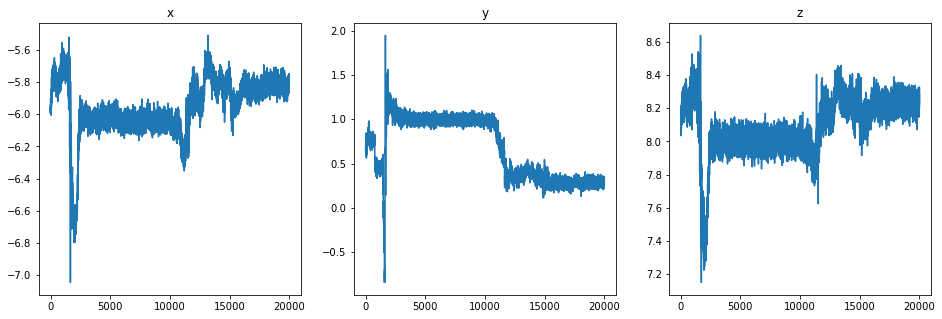

In [22]:
s2 = pd.DataFrame()
s2['x'] = butter_lowpass_filter(s1['x'], 0.1, 25)
s2['y'] = butter_lowpass_filter(s1['y'], 0.1, 25)
s2['z'] = butter_lowpass_filter(s1['z'], 0.1, 25)

plot_seqs(s1)

Analysis in frequency domain

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


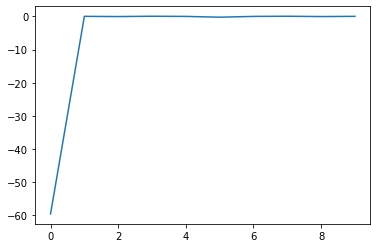

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


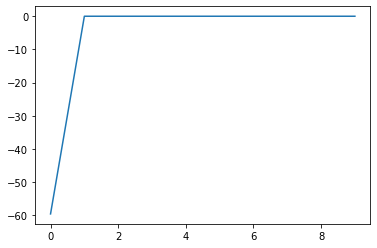

In [23]:
from scipy.fft import fft, ifft

s1 = s1[:10]
s2 = s2[:10]

x = fft(s1['x'].to_numpy())
plt.plot(x)
plt.show()

x = fft(s2['x'].to_numpy())
plt.plot(x)
plt.show()